# Algorithmus von Grover

Die Grover Suche ist einer der ersten klassischen Algorithmen, die die Überlegenheit der Quantencomputer gegenüber klassischen Computern zeigt. Von Grover selbst wurde der Suchalgorithmus mit der Suche in einer unstrukturierten Datenbank assoziiert. Dies ist allerdings falsch und führt häufig zu Problemen beim Verständnis des Orakels. Im folgenden wollen wir uns zuerst den Algorithmus anschauen, wobei wir das Orakel als Blackbox betrachten. Im Anschluss wollen wir uns mit dem Orakel näher beschäftigen und überlegen, wie man es effizient erstellen kann.

## Der Algorithmus

Mithilfe der Grover Suche kann man in einer (unsortierten) Menge von Daten nach einem speziellen oder mehreren Datenpunkten suchen. Die Größe der Menge ist dabei $N = 2^n$, wobei $n$ die Anzahl der Qubits entspricht. Das Element das Gesucht wird wird dabei vom Orakel mit einer negativen Amplitude markiert. Alle anderen Werte behalten ihre Amplitude. Im Anschluss wird ein Diffuser Operator verwendet, um alle Amplituden am aktuellen Mittelwert zu spiegeln. Dadurch verringert sich die Amplitude aller nicht gesuchten Werte und die des gesuchten Wertes wächst. Im folgenden ist das vorgehen grafisch dargestellt, wobei das Element $\hat{x}$ gesucht wird:

![](resources/grover_spiegelung.png)

Der Algorithmus startet in der gelichverteilten Superposition und führt $G(N)$ Grover-Iterationen durch. Wobei der Inhalt einer Iteration, wie oben bereits beschrieben, die Anwendung des Orakels gefolgt von dem Diffusor Operator ist. Führt man $G(N)\approx \frac{\pi}{4}\sqrt{N}$ Iterationen aus, so erhält man die höchste Amplitude für den gesuchten Wert. Würde man dann noch weitere Iterationen durchführen, so würde die Amplitude wieder sinken, bis man wieder beim Ausgangszustand, der gelichverteilten Superposition, ist. Aus der optimalen Anzahl von Operationen kann man auch die Laufzeit mit $\mathcal{O}(\sqrt{N})$ bestimmen. 

Statt nur nach einem Wert zu suchen kann man stattdessen auch nach max. $\lfloor\frac{N}{2} - 1\rfloor$ Datenpunkten in der Menge suchen.

### Das Orakel

Wie in der Einleitung bereits beschrieben, ist es unintuitiv, dass das Orakel den gesuchten Wert kennt und die Amplitude des Werts mit $-1$ multipliziert. Die ursrpüngliche Idee eines Orakels ist allerdings, dass sie uns als Blackbox gegeben ist und wir daher nicht in ihre Implementierung hineinschauen können.

Eine weitere Möglichkeit bietet der Einsatz von Quantum Dictionaries, die an die Stelle der gleichverteilten Superposition gesetzt werden. Wie sie funktionieren und was alles mit ihnen möglich ist soll weiter unten erklärt werden. Nur soviel vorab: Eine Anwendungsmöglichkeit ist, dass sie Funktionen implementieren können. Dazu haben sie ein Schlüssel- und ein Werteregister. Nun kann man nach bestimmten Werten (z.B. alle kleiner 7) im Werteregister suchen, ohne alle möglichen Werte zu kennen.

### Implementierung

Im folgenden ist der Grundlegende Schaltkreis für Grover dargestellt:

![Grover Algorithm](resources/grover_circuit_high_level.png)
(Quelle: https://qiskit.org/textbook/ch-algorithms/grover.html)

Das Orakel multipliziert die Amplituden aller gesuchten Zustönde mit $-1$ die zugehörige Matrix für den Zustand $|11\rangle$ bei der Verwendung von 2 Qubits würde demnach folgendermaßen aussehen:

$$\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & -1\\
\end{pmatrix}$$

Der Diffusor besteht aus 3 Komponenten. Zu Beginn haben wir auf allen Qubits ein Hadamard Gate. Im Anschluss werden alle Zustände außer $|0\rangle_n$ mit $-1$ multipliziert. Danach wird wieder auf alle Qubits ein Hadamard Gate angewendet.

#### Die Suche nach $|11\rangle$ auf 2 Qubits

Im folgenden soll das Beispiel für 2 Qubits mit der Suche nach $|11\rangle$ implementiert werden. Betrachten wir die Matrix für das Orakel, so fällt uns auf, dass sie dem $CZ$ Gate entspricht. Für die Implementierung des Diffusors benötigen wir noch Gates, die die folgende Matrix implementieren:

$$\begin{pmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & -1\\
\end{pmatrix}$$

Mit etwas probieren fällt auf, dass wir diese Matrix erzeugen können, wenn wir auf beiden Qubits zuerst ein $Z$ Gate anwenden und im Anschluss ein $CZ$ Gate. Als letztes müssen wir noch berechnen, wieviele Iterationen man benötigt. Dazu verwenden wir die Gleichung von oben: $G(N)\approx \frac{\pi}{4}\sqrt{N}$. Wir setzen für $N$ $4$ ein, da wir mit 2 Qubits 4 zustände kodieren können. Dadurch kommen wir auf die Lösung $\approx 1.57$. Wie wir sehen werden, werden wir genau eine Iteration benötigen.

In [1]:
import qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.providers.aer import AerSimulator
from qiskit.tools.jupyter import *

import matplotlib.pyplot as plt

import numpy as np

**Aufgabe 1:** Implementieren Sie den Schaltkreis für die Grover-Suche nach dem Zustand $|11\rangle$. Führen Sie den Schaltkreis auf dem `QASMSimulator` aus und lassen Sie sich das Histogram zeichnen.

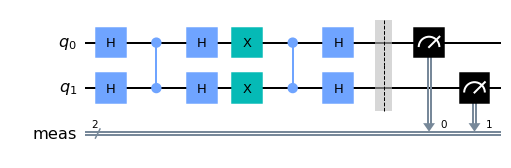

In [2]:
circ_11 = QuantumCircuit(2)

circ_11.h([0, 1])

circ_11.cz(0, 1)

circ_11.h([0, 1])
circ_11.x([0, 1])
circ_11.cz(0, 1)
circ_11.h([0, 1])

circ_11.measure_all()
circ_11.draw('mpl')

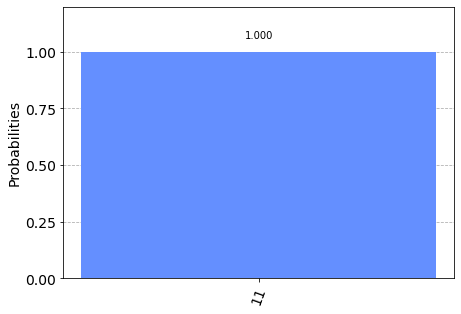

In [3]:
job = execute(circ_11, AerSimulator())
result = job.result()
counts = result.get_counts()

plot_histogram(counts)

#### Die Suche nach $|110\rangle$

Im folgenden soll die Suche auf 3 Qubits gezeigt werden. Hier wird es schon deutlich schwieriger die Matrizen durch Gates auszudrücken. Daher wollen wir nun qiskit die Umwandlung der Matrizen machen lassen.

**Aufgabe 2:** Implementieren Sie den Schaltkreis für die Grover-Suche nach dem Zustand $|110\rangle$. Verwenden Sie dazu `UnitaryGate` von Qiskit mit der korrekten Matrix. Führen Sie den Schaltkreis für eine verchiedene Anzahl von Iterationen auf dem `QASMSimulator` aus und lassen Sie sich die Histogramme zeichnen. Wieviele Iterationen waren notwendig?

In [4]:
qasm_backend = AerSimulator()

u_matrix_oracle = np.array([[ 1, 0, 0, 0, 0, 0, 0, 0], 
                            [ 0, 1, 0, 0, 0, 0, 0, 0], 
                            [ 0, 0, 1, 0, 0, 0, 0, 0], 
                            [ 0, 0, 0, 1, 0, 0, 0, 0], 
                            [ 0, 0, 0, 0, 1, 0, 0, 0], 
                            [ 0, 0, 0, 0, 0, 1, 0, 0], 
                            [ 0, 0, 0, 0, 0, 0,-1, 0], 
                            [ 0, 0, 0, 0, 0, 0, 0, 1]])

u_matrix_diff =  np.array([[ 1, 0, 0, 0, 0, 0, 0, 0], 
                           [ 0,-1, 0, 0, 0, 0, 0, 0], 
                           [ 0, 0,-1, 0, 0, 0, 0, 0], 
                           [ 0, 0, 0,-1, 0, 0, 0, 0], 
                           [ 0, 0, 0, 0,-1, 0, 0, 0], 
                           [ 0, 0, 0, 0, 0,-1, 0, 0], 
                           [ 0, 0, 0, 0, 0, 0,-1, 0], 
                           [ 0, 0, 0, 0, 0, 0, 0,-1]])

u_oracle_gate = qiskit.extensions.UnitaryGate(u_matrix_oracle, label='oracle')
u_diff_gate = qiskit.extensions.UnitaryGate(u_matrix_diff, label='diff')

diff_circ = QuantumCircuit(3)

diff_circ.h([0, 1, 2])
diff_circ.append(u_diff_gate, [0, 1, 2])
diff_circ.h([0, 1, 2])

diff_gate = diff_circ.to_gate()

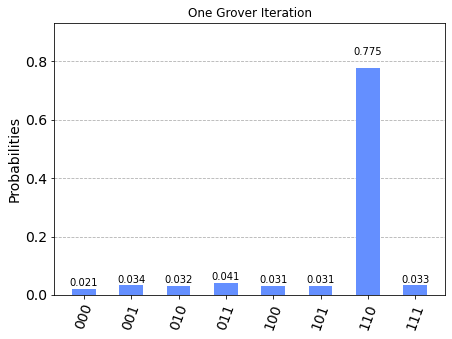

In [5]:
circ_110 = QuantumCircuit(3)

circ_110.h([0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])

circ_110.measure_all()

job_110 = execute(circ_110, qasm_backend, shots=1024)
result_110 = job_110.result()

plot_histogram(result_110.get_counts(), title='One Grover Iteration')

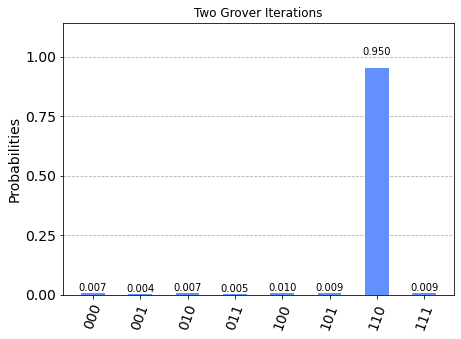

In [6]:
circ_110 = QuantumCircuit(3)

circ_110.h([0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])

circ_110.measure_all()

job_110 = execute(circ_110, qasm_backend, shots=1024)
best_result_110 = job_110.result()

plot_histogram(best_result_110.get_counts(), title='Two Grover Iterations')

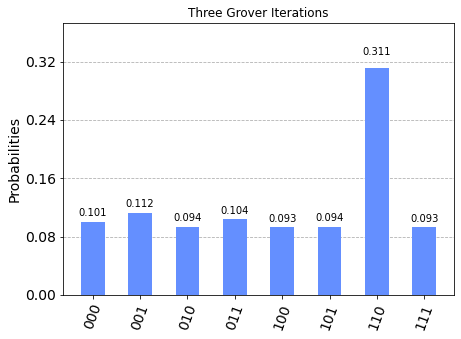

In [7]:
circ_110 = QuantumCircuit(3)

circ_110.h([0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])

circ_110.measure_all()

job_110 = execute(circ_110, qasm_backend, shots=1024)
result_110 = job_110.result()

plot_histogram(result_110.get_counts(), title='Three Grover Iterations')

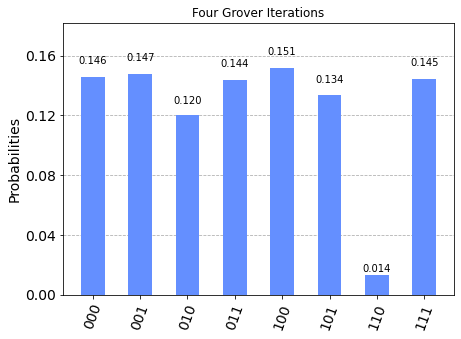

In [8]:
circ_110 = QuantumCircuit(3)

circ_110.h([0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])

circ_110.measure_all()

job_110 = execute(circ_110, qasm_backend, shots=1024)
result_110 = job_110.result()

plot_histogram(result_110.get_counts(), title='Four Grover Iterations')

#### Die Suche nach 3 Zuständen mit 3 Qubits

Wie oben bereits beschrieben, können wir auch mehrere Zustände mit Hilfe der Grover Suche finden. Dies soll im folgenden demonstriert werden. Das Orakel lässt sich einfach aus der vorherigen Demonstration übernehmen und anpassen. Auch hier soll wieder gezeigt werden, wie die Werte für die einzelnen Iterationen aussehen.

**Aufgabe 3:** Implementieren Sie den Schaltkreis für die Grover-Suche nach dem 3 beliebigen Zuständen. Verwenden Sie dazu das `UnitaryGate` von Qiskit mit der korrekten Matrix. Führen Sie den Schaltkreis für eine verchiedene Anzahl von Iterationen auf dem `QASMSimulator` aus und lassen Sie sich die Histogramme zeichnen. Wieviele Iterationen waren notwendig? Können wir nach noch mehr Werten auf 3 Qubits suchen?

In [9]:
u_matrix_oracle = np.array([[ 1, 0, 0, 0, 0, 0, 0, 0], 
                            [ 0, 1, 0, 0, 0, 0, 0, 0], 
                            [ 0, 0,-1, 0, 0, 0, 0, 0], 
                            [ 0, 0, 0, 1, 0, 0, 0, 0], 
                            [ 0, 0, 0, 0, 1, 0, 0, 0], 
                            [ 0, 0, 0, 0, 0,-1, 0, 0], 
                            [ 0, 0, 0, 0, 0, 0, 1, 0], 
                            [ 0, 0, 0, 0, 0, 0, 0,-1]])

u_oracle_gate = qiskit.extensions.UnitaryGate(u_matrix_oracle, label='oracle')



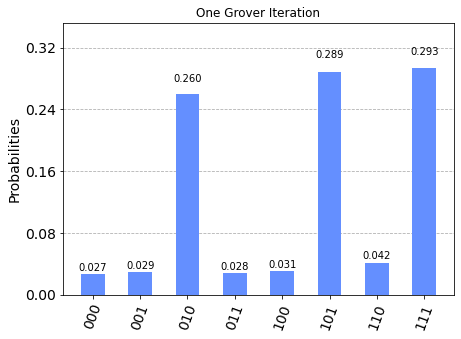

In [10]:
circ = QuantumCircuit(3)

circ.h([0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])

circ.measure_all()

job = execute(circ, qasm_backend, shots=1024)
result = job.result()

plot_histogram(result.get_counts(), title='One Grover Iteration')

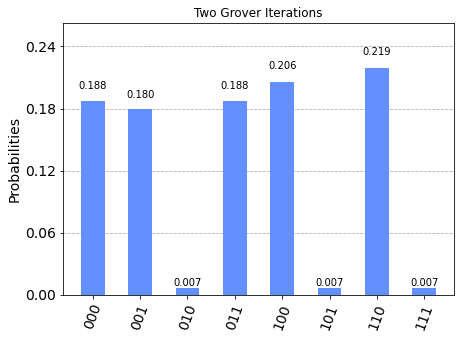

In [11]:
circ = QuantumCircuit(3)

circ.h([0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])

circ.measure_all()

job = execute(circ, qasm_backend, shots=1024)
result = job.result()

plot_histogram(result.get_counts(), title='Two Grover Iterations')

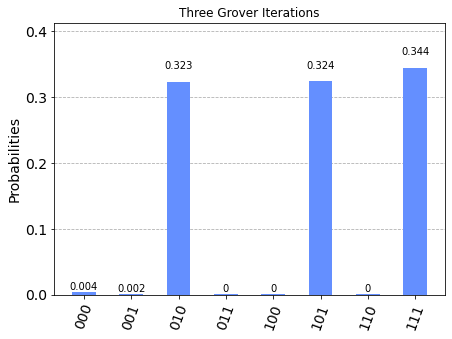

In [12]:
circ = QuantumCircuit(3)

circ.h([0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])
circ.append(u_oracle_gate, [0, 1, 2])
circ.append(diff_gate, [0, 1, 2])

circ.measure_all()

job = execute(circ, qasm_backend, shots=1024)
result = job.result()

plot_histogram(result.get_counts(), title='Three Grover Iterations')

**Bonus:** Führen Sie die Grover-Suche nach dem Zustand $|110\rangle$ entweder auf einem Quantencomputer aus oder nutzen Sie das Noisemodel eines Quantencomputers.

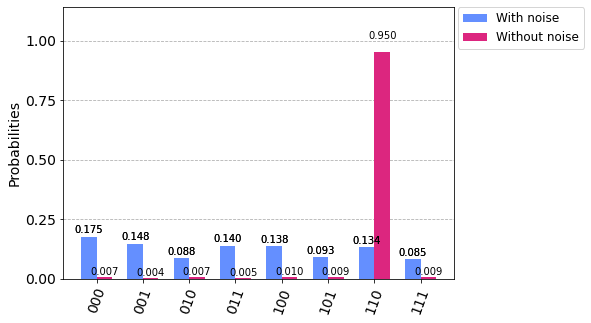

In [13]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

device_backend = provider.backend.ibm_oslo

# The device coupling map is needed for transpiling to correct
# CNOT gates before simulation
coupling_map = device_backend.configuration().coupling_map

# Construct the noise model from backend properties
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device_backend)

# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

circ_110 = QuantumCircuit(3)

circ_110.h([0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])
circ_110.append(u_oracle_gate, [0, 1, 2])
circ_110.append(diff_gate, [0, 1, 2])

circ_110.measure_all()

# Execute noisy simulation and get counts
result_noise = execute(circ_110, qasm_backend,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts()
plot_histogram([counts_noise, best_result_110.get_counts()], legend=['With noise', 'Without noise'])

**Bonus:** Noise mit 3 markierten Zuständen.

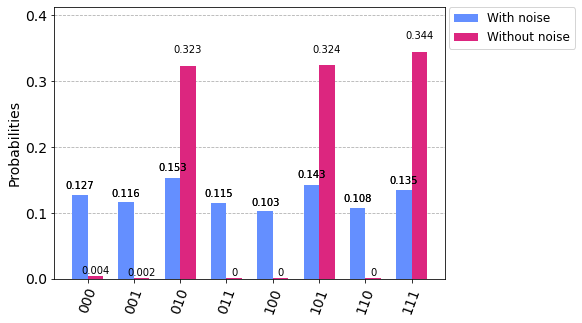

In [14]:
# Execute noisy simulation and get counts
result_noise = execute(circ, qasm_backend,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()
counts_noise = result_noise.get_counts()
plot_histogram([counts_noise, result.get_counts()], legend=['With noise', 'Without noise'])